<a href="https://colab.research.google.com/github/shkumar156/Object-Detection-in-Degraded-Images/blob/main/ObjectDetectionInDegradedImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install ultralytics opencv-python opencv-contrib-python matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
from google.colab import files

uploaded = files.upload()


Saving Car.jpg to Car.jpg



0: 640x640 1 car, 16.7ms
Speed: 2.8ms preprocess, 16.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


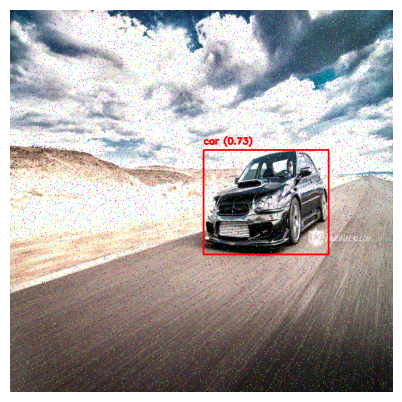

In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
# Installation and model setup
from ultralytics import YOLO

# Load a pretrained YOLO's model (highly recommended for better results)
model = YOLO('yolov8n.pt')

# PRO TIP: Replace 'model-yolov8.pt' with new 'model-yolov8u.pt'
# YOLOv8 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv8 models

def boxes(results, image):
    """
    Draws bounding boxes and labels on an image based on YOLO predictions.

    Args:
        results: YOLO model predictions containing bounding box coordinates, classes, and confidence scores.
        image: The image (numpy array) on which to draw the bounding boxes.

    Returns:
        The image with bounding boxes and labels drawn on it.
    """
    # Create a copy of the image to avoid modifying the original
    annotated_image = image.copy()

    # Extract predictions
    for result in results:
        for box in result.boxes:
            # Get bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].int().cpu().numpy()  # Convert tensor to integers
            label = result.names[int(box.cls[0])]         # Get class label
            confidence = box.conf[0].item()               # Get confidence score

            # Draw bounding box and label on the image
            cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Bounding box in blue
            cv2.putText(annotated_image, f"{label} ({confidence:.2f})", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Label in blue

    return annotated_image

# Image enhancement functions
def wiener_deblur(image):
    deblurred_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return deblurred_image

def unsharp_mask(image, sigma=1.0, strength=1.5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

def clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

def edge_enhance(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(sobel_x, sobel_y)
    magnitude = np.uint8(np.clip(magnitude, 0, 255))
    return cv2.cvtColor(magnitude, cv2.COLOR_GRAY2RGB)

def denoise(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

def guided_filter(image, radius=5, epsilon=0.2):
    image = np.float32(image)
    guide = image
    result = cv2.ximgproc.guidedFilter(guide, image, radius, epsilon)
    return np.uint8(np.clip(result, 0, 255))

def bilateral_sharpening(image, d=9, sigma_color=75, sigma_space=75):
    smoothed = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    sharpened = cv2.addWeighted(image, 1.5, smoothed, -0.5, 0)
    return sharpened

def laplacian_sharpening(image):
    # Convert the image to grayscale to get the laplacian
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply the Laplacian operator to detect edges
    laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
    # Convert Laplacian to uint8 (8-bit unsigned integer) for proper display
    laplacian = cv2.convertScaleAbs(laplacian)
    # Enhance the image by adding the laplacian to the original image
    sharpened = cv2.addWeighted(image, 1.2, cv2.cvtColor(laplacian, cv2.COLOR_GRAY2RGB), 1.2, -20)
    return sharpened

def sobel_edge_enhance(image):
    # Convert the image to grayscale for edge detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply Sobel filter in both x and y directions to detect edges
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    # Calculate the gradient magnitude
    magnitude = cv2.magnitude(sobel_x, sobel_y)
    # Normalize the magnitude to 8-bit
    magnitude = np.uint8(np.clip(magnitude, 0, 255))
    # Convert the magnitude back to RGB
    edge_image = cv2.cvtColor(magnitude, cv2.COLOR_GRAY2RGB)
    # Enhance edges: We can add the edge map back to the original image
    enhanced_image = cv2.addWeighted(image, 1, edge_image, 0.3, 0)
    return enhanced_image

def laplacian_of_gaussian(image, kernel_size=5, sigma=1.0, k=1.0):
    """Applies Laplacian of Gaussian (LoG) filtering to enhance edges in an RGB image.

    Args:
        image: The input RGB image (numpy array).
        kernel_size: The size of the LoG kernel (default: 5).
        sigma: Standard deviation for the Gaussian kernel (default: 1.0).
        k: Scaling factor for the Laplacian (default: 1.0).

    Returns:
        An enhanced RGB image (numpy array).
    """
    # Apply Gaussian blur to the image
    blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    # Calculate the Laplacian (second derivative)
    laplacian = cv2.Laplacian(blurred_image, cv2.CV_64F, ksize=kernel_size)
    # Convert Laplacian to uint8 for display and blending
    laplacian = cv2.convertScaleAbs(laplacian)
    # Enhance the image by adding the Laplacian to the original image
    enhanced_image = cv2.addWeighted(image, 1.0, laplacian, 0.5, 0)
    return enhanced_image

def gaussian_filter(image, kernel_size, sigma):
    """Applies a Gaussian filter to an image.

    Args:
        image: The input image (numpy array).
        kernel_size: The size of the Gaussian kernel (must be odd).
        sigma: Standard deviation of the Gaussian distribution.

    Returns:
        The filtered image (numpy array).
    """
    # Apply Gaussian blur using OpenCV
    filtered_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    return filtered_image

def enhance_image(image):
    # clip the values and convert to uint8
    image = np.clip(image, 0, 255)
    image = np.uint8(image)
    image = wiener_deblur(image)
    image = unsharp_mask(image)
    image = bilateral_sharpening(image)
    image = bilateral_sharpening(image)
    image = guided_filter(image)
    image = bilateral_sharpening(image)
    image = laplacian_of_gaussian(image, 3, 1.5)
    image = unsharp_mask(image)
    # image = gaussian_filter(image, 3, 1)
    return image

# Data loading and processing functions
def addNoiseAndBlur(image):
    noise = np.random.normal(0, 20, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

def addSaltPepperNoiseAndBrighten(image, salt_prob=0.02, pepper_prob=0.03, brightness_factor=1.2):
    # set the image dimensions
    row, col, ch = image.shape
    # Add salt and pepper noise
    noisy_image = image.copy()
    # Salt noise (set some pixels to white)
    salt = np.random.rand(row, col, ch) < salt_prob
    noisy_image[salt] = 255
    # Pepper noise (set some pixels to black)
    pepper = np.random.rand(row, col, ch) < pepper_prob
    noisy_image[pepper] = 0
    # Brighten the image by scaling the pixel values
    brightened_image = np.clip(noisy_image * brightness_factor, 0, 255).astype(np.uint8)
    return brightened_image

def reverseSaltPepperNoiseAndBrightness(noisy_brightened_image, salt_prob=0.05, pepper_prob=0.05, brightness_factor=1.2):
    # Step 1: Denoise the image using Median filtering to remove salt and pepper noise
    denoised_image = cv2.medianBlur(noisy_brightened_image, 5)  # 5x5 kernel
    # Step 2: Compensate for brightness adjustment by darkening the image (inverse of brightness factor)
    restored_image = np.clip(denoised_image / brightness_factor, 0, 255).astype(np.uint8)
    return restored_image

def contrastEnhance(image):
    (b, g, r) = cv2.split(image)
    # Apply histogram equalization on each channel
    r = cv2.equalizeHist(r)
    g = cv2.equalizeHist(g)
    b = cv2.equalizeHist(b)
    # Merge the channels back together
    image = cv2.merge([b, g, r])
    return image

# Example usage
plane = cv2.imread('/content/Car.jpg')
plane = cv2.resize(plane, (640, 640))
plane = cv2.cvtColor(plane, cv2.COLOR_BGR2RGB)

# Create the 'noisy' folder if it doesn't exist
if not os.path.exists('/content/noisy'):
    os.makedirs('/content/noisy')

files = os.listdir('/content/')
jpegs = [file for file in files if file.lower().endswith(('.jpg', '.jpeg'))]
noisy = []

for file in jpegs:
    noisy.append(addSaltPepperNoiseAndBrighten(cv2.cvtColor(cv2.resize(cv2.imread('/content/' + file), (640, 640)), cv2.COLOR_BGR2RGB)))

# Run predictions on noisy images
results = []
for img in noisy:
    results.append(model.predict(source=img))

# Display results
plt.figure(figsize=(12, 20))
for i, result in enumerate(results):
    plt.subplot(5, 2, i+1)
    plt.imshow(boxes(result, noisy[i]))
    plt.axis("off")
plt.tight_layout()